In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import plotly.express as px
import re
from sklearn.model_selection import train_test_split

In [2]:
# I don't use the 'test' dataset for the EDA in order to not be influenced by it during my choices of preprocessing
df = pd.read_csv('train.csv')
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [3]:
df.value_counts('target')/len(df)*100

target
0    57.034021
1    42.965979
dtype: float64

The dataset seems quite balanced in terms of target distribution.

In [4]:
print(df['keyword'].unique())

[nan 'ablaze' 'accident' 'aftershock' 'airplane%20accident' 'ambulance'
 'annihilated' 'annihilation' 'apocalypse' 'armageddon' 'army' 'arson'
 'arsonist' 'attack' 'attacked' 'avalanche' 'battle' 'bioterror'
 'bioterrorism' 'blaze' 'blazing' 'bleeding' 'blew%20up' 'blight'
 'blizzard' 'blood' 'bloody' 'blown%20up' 'body%20bag' 'body%20bagging'
 'body%20bags' 'bomb' 'bombed' 'bombing' 'bridge%20collapse'
 'buildings%20burning' 'buildings%20on%20fire' 'burned' 'burning'
 'burning%20buildings' 'bush%20fires' 'casualties' 'casualty'
 'catastrophe' 'catastrophic' 'chemical%20emergency' 'cliff%20fall'
 'collapse' 'collapsed' 'collide' 'collided' 'collision' 'crash' 'crashed'
 'crush' 'crushed' 'curfew' 'cyclone' 'damage' 'danger' 'dead' 'death'
 'deaths' 'debris' 'deluge' 'deluged' 'demolish' 'demolished' 'demolition'
 'derail' 'derailed' 'derailment' 'desolate' 'desolation' 'destroy'
 'destroyed' 'destruction' 'detonate' 'detonation' 'devastated'
 'devastation' 'disaster' 'displaced' 'droug

Many keywords in the dataset seem to be linked with the vocabulary of disasters.
Let's check some examples in terms of target distribution : 

In [5]:
keyword = 'typhoon'
print(f"target distribution on tweets with keyword identified as {keyword} : ")
df[df['keyword'] == keyword]['target'].value_counts()/len(df[df['keyword'] == keyword])

target distribution on tweets with keyword identified as typhoon : 


1    0.973684
0    0.026316
Name: target, dtype: float64

In [6]:
keyword = 'natural%20disaster'
print(f"target distribution on tweets with keyword identified as {keyword} : ")
df[df['keyword'] == keyword]['target'].value_counts()/len(df[df['keyword'] == keyword])

target distribution on tweets with keyword identified as natural%20disaster : 


1    0.529412
0    0.470588
Name: target, dtype: float64

In [7]:
keyword = 'military'
print(f"target distribution on tweets with keyword identified as {keyword} : ")
df[df['keyword'] == keyword]['target'].value_counts()/len(df[df['keyword'] == keyword])

target distribution on tweets with keyword identified as military : 


0    0.764706
1    0.235294
Name: target, dtype: float64

Let's plot if there is a significant difference of distribution of the target between the tweets for which a keyword or localization information is missing : 

In [8]:
px.histogram(df, x = df['location'].isna(), y = 'target', histfunc = 'avg')

The fact that having the localization filled or not does not influence the target distribution.

In [9]:
print(df['location'].unique())

[nan 'Birmingham' 'Est. September 2012 - Bristol' ... 'Vancouver, Canada'
 'London ' 'Lincoln']


To prevent potential overfitting on the dataset, and considering the hypothesis that disasters may occur anywhere, i choose to not consider the location information in that study. 

In [10]:
df = df.drop(columns = ['location'])
df

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
7608,10869,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,Police investigating after an e-bike collided ...,1


In [11]:
px.histogram(df, x = df['keyword'].isna(), y = 'target', histfunc = 'avg')

The presence of a keyword seems to be associated with a positive-skewed distribution of the target, I'll keep that variable.

## Language Preprocessing

In [12]:
px.box(df['text'].str.len())

The lengths of the tweets are quite long (median = 107 characters), so i will not only rely on SimpleRNN to build the model architecture (they are not sufficiently robust on long string lengths). 

Because we're in a classification problem, lemmatizing and removing some stop_words will probably not be a bad thing. 

In [13]:
!python -m spacy download en_core_web_md -q

2022-08-01 12:49:49.064998: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
     |████████████████████████████████| 42.8 MB 655 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [14]:
import en_core_web_md
nlp = en_core_web_md.load()

In [15]:
from spacy.lang.en.stop_words import STOP_WORDS

In [16]:
# Remove all non alphanumeric characters except whitespaces
df["text_clean"] = df["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch in [" ", "#", "@"]))
# remove double spaces and spaces at the beginning and end of strings
df["text_clean"] = df["text_clean"].apply(lambda x: re.sub(" +"," ",x).lower().strip())
# remove stop words and replace everyword with their lemma
#df["text_clean"] = df["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))
#df["text_clean"] = df["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))

In [17]:
df["text"].apply(lambda x : [ch.isalnum() or ch in [" ", "#", "@"] for ch in x])

0       [True, True, True, True, True, True, True, Tru...
1       [True, True, True, True, True, True, True, Tru...
2       [True, True, True, True, True, True, True, Tru...
3       [True, True, False, True, True, True, True, Tr...
4       [True, True, True, True, True, True, True, Tru...
                              ...                        
7608    [True, True, True, True, True, True, True, Tru...
7609    [True, True, True, True, True, False, True, Tr...
7610    [True, True, False, True, True, True, False, T...
7611    [True, True, True, True, True, True, True, Tru...
7612    [True, True, True, True, True, True, True, Tru...
Name: text, Length: 7613, dtype: object

In [18]:
df

,id,keyword,text,target,text_clean
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive #wildfires evacuation ord...
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...
...,...,...,...,...,...
7608,10869,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...
7609,10870,NaN,@aria_ahrary @TheTawniest The out of control w...,1,@ariaahrary @thetawniest the out of control wi...
7610,10871,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m194 0104 utc5km s of volcano hawaii httptcozd...
7611,10872,NaN,Police investigating after an e-bike collided ...,1,police investigating after an ebike collided w...


In [19]:
num_words = 1000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = num_words, oov_token = '<OOV>')
tokenizer.fit_on_texts(df.text_clean)
df["text_encoded"] = tokenizer.texts_to_sequences(df.text_clean)

df["len_text"] = df["text_encoded"].apply(lambda x: len(x))
df = df[df["len_text"]!=0]

In [20]:
df

,id,keyword,text,target,text_clean,text_encoded,len_text
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...,"[109, 1, 21, 2, 865, 6, 19, 241, 126, 1, 1, 70...",13
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[178, 43, 219, 678, 1, 1, 1]",7
2,5,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[40, 1, 1, 5, 1, 4, 649, 21, 121, 1, 18, 1, 41...",22
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive #wildfires evacuation ord...,"[1, 56, 1, 1, 247, 1, 4, 86]",8
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...,"[29, 92, 1, 19, 318, 20, 1, 1, 26, 255, 20, 1,...",16
...,...,...,...,...,...,...,...
7608,10869,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...,"[112, 817, 1, 1, 3, 342, 149, 66, 645, 194, 1]",11
7609,10870,NaN,@aria_ahrary @TheTawniest The out of control w...,1,@ariaahrary @thetawniest the out of control wi...,"[1, 1, 2, 36, 6, 812, 261, 108, 4, 86, 157, 4,...",20
7610,10871,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m194 0104 utc5km s of volcano hawaii httptcozd...,"[1, 1, 1, 207, 6, 573, 1, 1]",8
7611,10872,NaN,Police investigating after an e-bike collided ...,1,police investigating after an ebike collided w...,"[76, 1, 38, 42, 1, 316, 14, 3, 122, 4, 260, 1,...",19


In [21]:
px.box(df['len_text'])

In [22]:
len(tokenizer.index_word)

22866

In [23]:
#train, val, y_train, y_val = train_test_split(df['text_encoded'], df['target'], random_state = 0, stratify = df['target'], test_size = 0.3)

In [24]:
padded_array = tf.keras.preprocessing.sequence.pad_sequences(df['text_encoded'], padding="post")
padded_array

array([[109,   1,  21, ...,   0,   0,   0],
       [178,  43, 219, ...,   0,   0,   0],
       [ 40,   1,   1, ...,   0,   0,   0],
       ...,
       [  1,   1,   1, ...,   0,   0,   0],
       [ 76,   1,  38, ...,   0,   0,   0],
       [  2, 198,  52, ...,   0,   0,   0]], dtype=int32)

In [25]:
df['text_encoded_padded'] = pd.Series(list(padded_array))
df

,id,keyword,text,target,text_clean,text_encoded,len_text,text_encoded_padded
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...,"[109, 1, 21, 2, 865, 6, 19, 241, 126, 1, 1, 70...",13,"[109, 1, 21, 2, 865, 6, 19, 241, 126, 1, 1, 70..."
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[178, 43, 219, 678, 1, 1, 1]",7,"[178, 43, 219, 678, 1, 1, 1, 0, 0, 0, 0, 0, 0,..."
2,5,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[40, 1, 1, 5, 1, 4, 649, 21, 121, 1, 18, 1, 41...",22,"[40, 1, 1, 5, 1, 4, 649, 21, 121, 1, 18, 1, 41..."
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive #wildfires evacuation ord...,"[1, 56, 1, 1, 247, 1, 4, 86]",8,"[1, 56, 1, 1, 247, 1, 4, 86, 0, 0, 0, 0, 0, 0,..."
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...,"[29, 92, 1, 19, 318, 20, 1, 1, 26, 255, 20, 1,...",16,"[29, 92, 1, 19, 318, 20, 1, 1, 26, 255, 20, 1,..."
...,...,...,...,...,...,...,...,...
7608,10869,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...,"[112, 817, 1, 1, 3, 342, 149, 66, 645, 194, 1]",11,"[112, 817, 1, 1, 3, 342, 149, 66, 645, 194, 1,..."
7609,10870,NaN,@aria_ahrary @TheTawniest The out of control w...,1,@ariaahrary @thetawniest the out of control wi...,"[1, 1, 2, 36, 6, 812, 261, 108, 4, 86, 157, 4,...",20,"[1, 1, 2, 36, 6, 812, 261, 108, 4, 86, 157, 4,..."
7610,10871,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m194 0104 utc5km s of volcano hawaii httptcozd...,"[1, 1, 1, 207, 6, 573, 1, 1]",8,"[1, 1, 1, 207, 6, 573, 1, 1, 0, 0, 0, 0, 0, 0,..."
7611,10872,NaN,Police investigating after an e-bike collided ...,1,police investigating after an ebike collided w...,"[76, 1, 38, 42, 1, 316, 14, 3, 122, 4, 260, 1,...",19,"[76, 1, 38, 42, 1, 316, 14, 3, 122, 4, 260, 1,..."


In [26]:
train, val, y_train, y_val = train_test_split(padded_array, df['target'], random_state = 0, stratify = df['target'], test_size = 0.3) # split on the dataframes to keep track of the index

In [27]:
print(train.shape)
print(val.shape)

(5329, 31)
(2284, 31)


In [28]:
train_ds = tf.data.Dataset.from_tensor_slices((train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((val, y_val))

train_ds = train_ds.shuffle(len(train_ds)).batch(128)
val_ds = val_ds.shuffle(len(val_ds)).batch(128)

In [29]:
embedding_dim=4 # the dimensionality of the representation space
#vocab_size = len(tokenizer.word_index) + 1
vocab_size = num_words 

model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, name="embedding", input_length = (train.shape[-1])), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  #tf.keras.layers.LSTM(units=64, return_sequences=True), # maintains the sequential nature
  tf.keras.layers.LSTM(units=4, return_sequences=False), # returns the last output
  #tf.keras.layers.Dense(8, activation='relu'), # a dense layer
  tf.keras.layers.Dense(1, activation="sigmoid") # the prediction layer
])

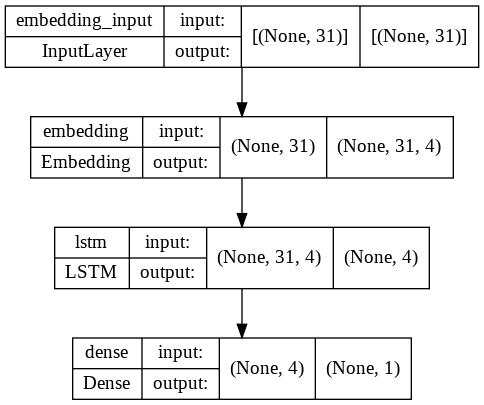

In [30]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [31]:
!pip install tensorflow-addons -q
import tensorflow_addons as tfa

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy',tfa.metrics.F1Score(num_classes = 2, average = 'micro', threshold = 0.5)])

In [32]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30)

Epoch 1/30
42/42 [==============================] - 4s 35ms/step - loss: 0.6864 - accuracy: 0.5703 - f1_score: 0.0000e+00 - val_loss: 0.6837 - val_accuracy: 0.5705 - val_f1_score: 0.0000e+00
Epoch 2/30
42/42 [==============================] - 1s 18ms/step - loss: 0.6834 - accuracy: 0.5703 - f1_score: 0.0000e+00 - val_loss: 0.6830 - val_accuracy: 0.5705 - val_f1_score: 0.0000e+00
Epoch 3/30
42/42 [==============================] - 1s 23ms/step - loss: 0.6829 - accuracy: 0.5703 - f1_score: 0.0000e+00 - val_loss: 0.6826 - val_accuracy: 0.5705 - val_f1_score: 0.0000e+00
Epoch 4/30
42/42 [==============================] - 1s 32ms/step - loss: 0.6817 - accuracy: 0.5703 - f1_score: 0.0000e+00 - val_loss: 0.6804 - val_accuracy: 0.5705 - val_f1_score: 0.0000e+00
Epoch 5/30
42/42 [==============================] - 1s 34ms/step - loss: 0.6669 - accuracy: 0.5703 - f1_score: 0.0000e+00 - val_loss: 0.6373 - val_accuracy: 0.5705 - val_f1_score: 0.0000e+00
Epoch 6/30
42/42 [===========================

In [33]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=model.history.history["loss"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=model.history.history["val_loss"],
                    mode='lines',
                    name='val_loss'))
fig.show()

In [34]:
model.history.history.keys()

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score'])

In [35]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=model.history.history["f1_score"],
                    mode='lines',
                    name='f1_score'))
fig.add_trace(go.Scatter(y=model.history.history["val_f1_score"],
                    mode='lines',
                    name='val_f1_score'))
fig.show()

# Predictions inspection

In [36]:
train, y_train

(array([[  1,  15,  23, ...,   0,   0,   0],
        [  9,   1, 116, ...,   0,   0,   0],
        [ 13,   1,   9, ...,   0,   0,   0],
        ...,
        [  1, 831,  44, ...,   0,   0,   0],
        [  1, 141,   5, ...,   0,   0,   0],
        [ 46,   1, 642, ...,   0,   0,   0]], dtype=int32), 4812    1
 2080    0
 652     0
 3528    0
 3007    1
        ..
 7248    0
 7606    1
 1885    0
 3865    0
 3397    0
 Name: target, Length: 5329, dtype: int64)

In [37]:
df['pred'] = 'no prediction'

In [38]:
model(train)

<tf.Tensor: shape=(5329, 1), dtype=float32, numpy=
array([[0.92227143],
       [0.10512394],
       [0.10066417],
       ...,
       [0.10555869],
       [0.10110563],
       [0.10011786]], dtype=float32)>

In [39]:
df.loc[y_train.index,'pred'] = model(train)
df.loc[y_val.index,'pred'] = model(val)

In [40]:
df

,id,keyword,text,target,text_clean,text_encoded,len_text,text_encoded_padded,pred
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...,"[109, 1, 21, 2, 865, 6, 19, 241, 126, 1, 1, 70...",13,"[109, 1, 21, 2, 865, 6, 19, 241, 126, 1, 1, 70...",0.887465
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[178, 43, 219, 678, 1, 1, 1]",7,"[178, 43, 219, 678, 1, 1, 1, 0, 0, 0, 0, 0, 0,...",0.8442
2,5,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[40, 1, 1, 5, 1, 4, 649, 21, 121, 1, 18, 1, 41...",22,"[40, 1, 1, 5, 1, 4, 649, 21, 121, 1, 18, 1, 41...",0.926777
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive #wildfires evacuation ord...,"[1, 56, 1, 1, 247, 1, 4, 86]",8,"[1, 56, 1, 1, 247, 1, 4, 86, 0, 0, 0, 0, 0, 0,...",0.89741
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...,"[29, 92, 1, 19, 318, 20, 1, 1, 26, 255, 20, 1,...",16,"[29, 92, 1, 19, 318, 20, 1, 1, 26, 255, 20, 1,...",0.136073
...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...,"[112, 817, 1, 1, 3, 342, 149, 66, 645, 194, 1]",11,"[112, 817, 1, 1, 3, 342, 149, 66, 645, 194, 1,...",0.921866
7609,10870,NaN,@aria_ahrary @TheTawniest The out of control w...,1,@ariaahrary @thetawniest the out of control wi...,"[1, 1, 2, 36, 6, 812, 261, 108, 4, 86, 157, 4,...",20,"[1, 1, 2, 36, 6, 812, 261, 108, 4, 86, 157, 4,...",0.927207
7610,10871,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m194 0104 utc5km s of volcano hawaii httptcozd...,"[1, 1, 1, 207, 6, 573, 1, 1]",8,"[1, 1, 1, 207, 6, 573, 1, 1, 0, 0, 0, 0, 0, 0,...",0.891109
7611,10872,NaN,Police investigating after an e-bike collided ...,1,police investigating after an ebike collided w...,"[76, 1, 38, 42, 1, 316, 14, 3, 122, 4, 260, 1,...",19,"[76, 1, 38, 42, 1, 316, 14, 3, 122, 4, 260, 1,...",0.910571


In [41]:
y_train.sort_index()

1       1
3       1
5       1
6       1
7       1
       ..
7607    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 5329, dtype: int64

In [42]:
(df['pred'] == 'no prediction').sum()

0

In [43]:
df['pred_binary'] = df['pred'].apply(lambda x : 1 if x > 0.5 else 0)
df

,id,keyword,text,target,text_clean,text_encoded,len_text,text_encoded_padded,pred,pred_binary
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...,"[109, 1, 21, 2, 865, 6, 19, 241, 126, 1, 1, 70...",13,"[109, 1, 21, 2, 865, 6, 19, 241, 126, 1, 1, 70...",0.887465,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[178, 43, 219, 678, 1, 1, 1]",7,"[178, 43, 219, 678, 1, 1, 1, 0, 0, 0, 0, 0, 0,...",0.8442,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[40, 1, 1, 5, 1, 4, 649, 21, 121, 1, 18, 1, 41...",22,"[40, 1, 1, 5, 1, 4, 649, 21, 121, 1, 18, 1, 41...",0.926777,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive #wildfires evacuation ord...,"[1, 56, 1, 1, 247, 1, 4, 86]",8,"[1, 56, 1, 1, 247, 1, 4, 86, 0, 0, 0, 0, 0, 0,...",0.89741,1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...,"[29, 92, 1, 19, 318, 20, 1, 1, 26, 255, 20, 1,...",16,"[29, 92, 1, 19, 318, 20, 1, 1, 26, 255, 20, 1,...",0.136073,0
...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...,"[112, 817, 1, 1, 3, 342, 149, 66, 645, 194, 1]",11,"[112, 817, 1, 1, 3, 342, 149, 66, 645, 194, 1,...",0.921866,1
7609,10870,NaN,@aria_ahrary @TheTawniest The out of control w...,1,@ariaahrary @thetawniest the out of control wi...,"[1, 1, 2, 36, 6, 812, 261, 108, 4, 86, 157, 4,...",20,"[1, 1, 2, 36, 6, 812, 261, 108, 4, 86, 157, 4,...",0.927207,1
7610,10871,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m194 0104 utc5km s of volcano hawaii httptcozd...,"[1, 1, 1, 207, 6, 573, 1, 1]",8,"[1, 1, 1, 207, 6, 573, 1, 1, 0, 0, 0, 0, 0, 0,...",0.891109,1
7611,10872,NaN,Police investigating after an e-bike collided ...,1,police investigating after an ebike collided w...,"[76, 1, 38, 42, 1, 316, 14, 3, 122, 4, 260, 1,...",19,"[76, 1, 38, 42, 1, 316, 14, 3, 122, 4, 260, 1,...",0.910571,1


In [44]:
df['good_pred'] = (df['target'] == df['pred_binary'])
df

,id,keyword,text,target,text_clean,text_encoded,len_text,text_encoded_padded,pred,pred_binary,good_pred
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...,"[109, 1, 21, 2, 865, 6, 19, 241, 126, 1, 1, 70...",13,"[109, 1, 21, 2, 865, 6, 19, 241, 126, 1, 1, 70...",0.887465,1,True
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[178, 43, 219, 678, 1, 1, 1]",7,"[178, 43, 219, 678, 1, 1, 1, 0, 0, 0, 0, 0, 0,...",0.8442,1,True
2,5,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[40, 1, 1, 5, 1, 4, 649, 21, 121, 1, 18, 1, 41...",22,"[40, 1, 1, 5, 1, 4, 649, 21, 121, 1, 18, 1, 41...",0.926777,1,True
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive #wildfires evacuation ord...,"[1, 56, 1, 1, 247, 1, 4, 86]",8,"[1, 56, 1, 1, 247, 1, 4, 86, 0, 0, 0, 0, 0, 0,...",0.89741,1,True
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...,"[29, 92, 1, 19, 318, 20, 1, 1, 26, 255, 20, 1,...",16,"[29, 92, 1, 19, 318, 20, 1, 1, 26, 255, 20, 1,...",0.136073,0,False
...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...,"[112, 817, 1, 1, 3, 342, 149, 66, 645, 194, 1]",11,"[112, 817, 1, 1, 3, 342, 149, 66, 645, 194, 1,...",0.921866,1,True
7609,10870,NaN,@aria_ahrary @TheTawniest The out of control w...,1,@ariaahrary @thetawniest the out of control wi...,"[1, 1, 2, 36, 6, 812, 261, 108, 4, 86, 157, 4,...",20,"[1, 1, 2, 36, 6, 812, 261, 108, 4, 86, 157, 4,...",0.927207,1,True
7610,10871,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m194 0104 utc5km s of volcano hawaii httptcozd...,"[1, 1, 1, 207, 6, 573, 1, 1]",8,"[1, 1, 1, 207, 6, 573, 1, 1, 0, 0, 0, 0, 0, 0,...",0.891109,1,True
7611,10872,NaN,Police investigating after an e-bike collided ...,1,police investigating after an ebike collided w...,"[76, 1, 38, 42, 1, 316, 14, 3, 122, 4, 260, 1,...",19,"[76, 1, 38, 42, 1, 316, 14, 3, 122, 4, 260, 1,...",0.910571,1,True


In [45]:
df_val = df.loc[y_val.index]
df_val

,id,keyword,text,target,text_clean,text_encoded,len_text,text_encoded_padded,pred,pred_binary,good_pred
5305,7578,outbreak,Families to sue over Legionnaires: More than 4...,1,families to sue over legionnaires more than 40...,"[125, 5, 628, 64, 188, 52, 77, 386, 125, 496, ...",18,"[125, 5, 628, 64, 188, 52, 77, 386, 125, 496, ...",0.93852,1,True
4279,6078,heat%20wave,Longest Streak of Triple-Digit Heat Since 2013...,1,longest streak of tripledigit heat since 2013 ...,"[1, 1, 6, 1, 281, 231, 1, 1, 4, 1, 1, 1]",12,"[1, 1, 6, 1, 281, 231, 1, 1, 4, 1, 1, 1, 0, 0,...",0.930218,1,True
740,1071,bleeding,@tammy_w1997 @ElijahMallari bleeding wild thin...,0,@tammyw1997 @elijahmallari bleeding wild thing...,"[1, 1, 444, 261, 415, 889, 366, 2, 1, 225, 286...",16,"[1, 1, 444, 261, 415, 889, 366, 2, 1, 225, 286...",0.723576,1,False
6669,9557,threat,Meek Mill responds to DrakeÛªs OVO Fest set w...,1,meek mill responds to drakeûªs ovo fest set wi...,"[851, 1, 1, 5, 1, 1, 1, 256, 14, 1, 1, 1]",12,"[851, 1, 1, 5, 1, 1, 1, 256, 14, 1, 1, 1, 0, 0...",0.232966,0,False
1268,1827,burned,Burned my popcorn??,0,burned my popcorn,"[351, 13, 1]",3,"[351, 13, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.099952,0,True
...,...,...,...,...,...,...,...,...,...,...,...
215,303,annihilated,Be annihilated for status education mba on beh...,0,be annihilated for status education mba on beh...,"[22, 535, 10, 1, 1, 1, 11, 1, 6, 3, 11, 1, 702...",16,"[22, 535, 10, 1, 1, 1, 11, 1, 6, 3, 11, 1, 702...",0.935905,1,False
5618,8016,refugees,#retweet Cameroon repatriating about 12000 Nig...,1,#retweet cameroon repatriating about 12000 nig...,"[1, 1, 1, 53, 1, 1, 317, 550, 5, 1, 1, 1]",12,"[1, 1, 1, 53, 1, 1, 317, 550, 5, 1, 1, 1, 0, 0...",0.917286,1,True
5358,7647,panic,Obligatory middle of the night panic attack,0,obligatory middle of the night panic attack,"[1, 1, 6, 2, 248, 346, 111]",7,"[1, 1, 6, 2, 248, 346, 111, 0, 0, 0, 0, 0, 0, ...",0.104171,0,True
3385,4847,evacuation,INK Entertainment Addresses Veld Evacuation an...,0,ink entertainment addresses veld evacuation an...,"[1, 1, 1, 1, 247, 7, 1, 1, 1, 1, 50, 1]",12,"[1, 1, 1, 1, 247, 7, 1, 1, 1, 1, 50, 1, 0, 0, ...",0.918422,1,False


In [46]:
df_val_tp =  df_val[(df_val['good_pred'] == True) & (df_val['pred_binary'] == 1)]
df_val_tn =  df_val[(df_val['good_pred'] == True) & (df_val['pred_binary'] == 0)]
df_val_fp =  df_val[(df_val['good_pred'] == False) & (df_val['pred_binary'] == 1)]
df_val_fn =  df_val[(df_val['good_pred'] == False) & (df_val['pred_binary'] == 0)]
precision = len(df_val_tp) / (len(df_val_tp) + len(df_val_fp))
recall = len(df_val_tp) / (len(df_val_tp) + len(df_val_fn))
f1_score = 2 * recall * precision / (recall + precision)
print("Precision : ", precision)
print("Recall : ", recall)
print("F1-score : ", f1_score)

Precision :  0.7538126361655774
Recall :  0.7054026503567788
F1-score :  0.7288046340179042


In [47]:
pd.options.display.max_colwidth = 200
print("False Negatives :")
print()
df_val_fn['text'].sample(20, random_state = 0)

False Negatives :



1632             I was on my way to Gary but all the Chicago entrances was closed due to a bridge collapsed ?????? I hope they let us through tomorrow
5200       WACKOS like #MicheleBachman predict the WORLD will SOON be OBLITERATED by a burning firey INFERNO but cant accept #GlobalWarming!! HELLO!!!
3356                                Is it seclusion when a class is evacuated and a child is left alone in the class to force compliance?  #MoreVoices
5540    Radioactive Box Quarantined - IsraelÛªs Ashdod Port was evacuated when emergency teams discovered radiation emittin... http://t.co/swQ5lMyDka
5328                                                                                   I'll be at SFA very soon....#Pandemonium http://t.co/RW8b50xz9m
3785          Former Township fire truck being used in Philippines: Township of Langley assistant fire chief Pat Walker spen... http://t.co/r6YJw4xcKY
1366       Where are the protests ? The riots? The burning buildings? How come you don't see a

In [48]:
print("True Negatives :")
print()
df_val_tn['text'].sample(20, random_state = 0)

True Negatives :



1622                                                                     '60 all out? What!' - World reacts to Aussie collapse http://t.co/I6zQlk2Puz
5333                                                           Pandemonium In Aba As Woman Delivers Baby Without Face (Photos) http://t.co/AcFI2rHz4N
346                                                         Beyonce Is my pick for http://t.co/nnMQlz91o9 Fan Army #Beyhive http://t.co/o91f3cYy0R 77
1041                         Womens Tote Faux Leather Handbags Shoulder Cross Body Top Handle Bags Rose http://t.co/GYzPisBI1u http://t.co/mSDnTkWYaf
5678                                   Man Who Buried Dog Alive Thought No One Would Find Her But She Was Rescued Just In Time http://t.co/SahQ5UOAHW
1887                          http://t.co/kG5pLkeDhr WRAPUP 2-U.S. cable TV companies' shares crushed after Disney disappoints http://t.co/QeIhvn3DNQ
4723                             'I may have gotten a little too exited over my (home made) lava lam

In [49]:
print("False Positives :")
print()
df_val_fp['text'].sample(20, random_state = 0)

False Positives :



1318                                                                         @nagel_ashley @Vicken52 @BasedLaRock @goonc1ty rip the world... its burning
619                         In Lies We Trust #dvd CIA Hollywood and Bioterrorism Len Horowitz Vaccines Nwo http://t.co/6PAGJqfbzK http://t.co/qzizElxbyr
221                                                       BOOM! Your country was just entirely annihilated by a hÛ_ ÛÓ Britain https://t.co/IrFCn71sZv
4578          @fkhanage look what Shad Forsythe has done in 1 year we won't have as many injuries as before we will inevitably have injuries like others
4376                                             Governor weighs parole for California school bus hijacker http://t.co/7NPBfRzEJL http://t.co/Y0kByy8nce
6240                                Sassy city girl country hunk stranded in Smoky Mountain snowstorm #AoMS http://t.co/ZDJ2hyF6RO #ibooklove #bookboost
3155         The eyes of the nation &amp; broader conservation community are on #A

In [50]:
print("True Positives :")
print()
df_val_tp['text'].sample(20, random_state = 0)

True Positives :



471     India shud not give any evidence 2 pak.They will share with terrorists &amp; use for next attack.Share with oth contries https://t.co/qioPbTIUVu
5710        VIDEO: 'We're picking up bodies from water' - Rescuers are searching for hundreds of migrants in the Mediterranean... http://t.co/yhQU5UV6Ok
3345                                                     Our thoughts are with these local residents! Time for some heavy rain!!! http://t.co/x3g2OX6K8R
2071            beforeitsnews : Hundreds feared dead after Libyan migrant boat capsizes during rescue Û_ http://t.co/MjoeeBDLXn) http://t.co/fvEn1ex0PS
4097                                                                Central Mass. fruit trees escape heavy damage after wind hail http://t.co/VbFfodtP6M
1712                                                             Two trains have collided in India. Please pray for victims their families and rescuers.
7517            Wreckage 'Conclusively Confirmed' as From MH370: Malaysia PM: Inve